# <center>Classification model of fake reviews</center> 

In [2]:
from google.cloud import storage
from io import BytesIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer

import collections
from collections import OrderedDict
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, pairwise_distances

import pickle

pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Data preprocesing

In [3]:
# Import the data from the bucket (reviews from the las 365 days)
bucket_name = "dataproc-098183eb-e885-45d7-9bbd-3c3b25a996ef-eu"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

blob = storage.blob.Blob("notebooks/reviews_366.csv",bucket)

content = blob.download_as_string()

df_reviews = pd.read_csv(BytesIO(content))

In [4]:
# See how many published and removed reviews from the platform (we are just going to use these two classes to train the model) 
df_reviews.TestimonialStatus.value_counts()

verification-recieved    191849
removed-from-site         33636
verification-send-2         421
in-process                   23
write-review-step            13
special-attention             6
verification-send             3
testimonial-abuse             2
Name: TestimonialStatus, dtype: int64

In [10]:
# Reasons to remove a review from the site
df_reviews.TestimonialReason.value_counts()

Poor motivation                    12994
Duplicate                           6315
Placed incorrectly                  4205
Suspect fraud                       3521
GA_Remove                           2017
Internally forwarded for review     1883
Not visited                         1285
Personal                             304
Fraud                                296
Owner                                198
Email_Remove                         147
Offensive language                    91
Chat - discussion                     41
Advertising                           38
Filter word detected                   6
Name: TestimonialReason, dtype: int64

Select just reviews that were already verified or removed from the platform (except removed from site due to placed incorrecrly). Placed incorrectly reffers to reviews that were not placed in the correct accommodation or they were written in a different language.



In [5]:
df_class = df_reviews.loc[(df_reviews["TestimonialStatus"] == "verification-recieved") | ((df_reviews["TestimonialStatus"] == "removed-from-site") & (df_reviews['TestimonialReason'] != "Placed incorrectly"))]


In [6]:
df_class = df_class[["TestimonialStatus"
                     ,"TestimonialID"
                     ,"EntityID"
                     ,"EntityIDAccommodation"
                     ,"EntityIDCountry"
                     ,"TestimonialTimestamp"
                     ,"TestimonialRating_01_GeneralImpression"
                     ,"CustomerEmail"
                     ,"CustomerIP"
                     ,"TestimonialTextRemark"
                     ,"AccommodationTypeID"]]

## 2. Data cleaning and feature engineering

#### The target feature:
    
   - TestimonialOffline: Usinng the TestimonialStatus feature we create a categorical variable which gets the value of 1 if the review was removed from the site (offline) and 0 if the review was verified (online).

#### The following features I will use as explanatory features or to create new features in the next step:

   - EntityID: all IDs accommodation, destination, area, country
   - Accommodation: Categorical variable that gets the value of 1 if it is an acco 0 otherwise (destination, area, country)
   - EntityIDCountry: country
   - TestimonialTimestamp: when was the review written
   - TestimonialRating_01_GeneralImpression (general score (missing values with the average score of the acco)
   - CustomerEmail
   - CustomerIP
   - TestimonialTextRemark: text of the review
   - AccommodationTypeID (replace nan values with 100 for example, they are destination, areas o countries)
   

Additionally, I just select the reviews with non nan in customerIP and non CustomerEmail. So we don't have the customerID of 3 reviews. (From 221280 reviews to 221277)

In [7]:
def data_cleanning (df, customer_col, email_col, reviewID_col, date_time_col, status_col, entityIDacco_col, 
                    score_col, entityid_col, acco_type_col):
    
    # Remove rows with non CustomerIP and non CustomerEmail (very few rows 3)
    df = df.dropna(subset=[customer_col])
    df = df.dropna(subset=[email_col])
    
    # Remove duplicate TestimonialID
    df.drop_duplicates([reviewID_col], keep='first', inplace=True)
    
    # Set date_time_col to datetime format and create new cols just with the date and hour of the review
    df[date_time_col] = df[date_time_col].apply(lambda x: pd.to_datetime(str(x)))
    df['date'] = df[date_time_col].dt.date
    df['hour'] = df[date_time_col].dt.hour
    
    # Create target variable: Testimonial_online variable
    df['Testimonial_offline'] = (df[status_col]=='removed-from-site').astype(int)
    
    #Creat is_acco_review variable: if the review is of an accommodation then we will have value 1 and 0 otherwise 
    #(review of destination, area or country with value 0).
    df[entityIDacco_col].fillna(0, inplace=True)
    df['is_acco_review'] = (df[entityIDacco_col] !=0).astype(int) 

    # Create the score column with the mean value of that entityid but we don't have all entityID in the sample 
    # So we will have some nan values that will be fill with the mean value of all the scores in the sample
    df['Score'] = df[score_col].fillna(df.groupby(entityid_col)[score_col].transform('mean'))
    df.fillna({'Score': df.Score.mean()}, inplace=True)

    # Accotype 
    df[acco_type_col].fillna("no_acco", inplace=True)
    cleanup_accoType = {acco_type_col:  {1: "Aparthotel", 2: "Appartement"
                                            , 3: "Bed_breakfast", 4: "Bungalow"
                                            , 5: "Bungalowtent", 6: "Camping"
                                            , 7: "Chalet", 8: "Cruiseschip"
                                            , 9: "Gasthof" , 10: "Hostel"
                                            , 11: "Hotel", 12: "Kasteel"
                                            , 13: "Landhuis", 14: "Overig"
                                            , 15: "Pension", 16: "Vakantiehuis"
                                            , 17: "Villa", 18: "Vakantiepark"
                                            , 19: "Onbekend", 20: "Lodge"
                                            , 21: "sport_natuur", 22: "history_culture"
                                            , 23: "overig_poi", 24: "horeca"
                                            , 25: "attracties", 26: "onbeach"
                                            , 27: "restaurant"}}
    df.replace(cleanup_accoType, inplace=True)
    
    print('Data Cleaning Complete')
    return df

In [8]:
df_class = data_cleanning(df=df_class, customer_col='CustomerIP', email_col='CustomerEmail', reviewID_col='TestimonialID',
              date_time_col='TestimonialTimestamp', status_col='TestimonialStatus', 
               entityIDacco_col='EntityIDAccommodation', score_col='TestimonialRating_01_GeneralImpression', 
               entityid_col='EntityID', acco_type_col='AccommodationTypeID')

Data Cleaning Complete


In [9]:
def text_cleaning(df, text_col):
    #Remove stop words
    stopword_list = nltk.corpus.stopwords.words('dutch')
    my_stopwords= ['wij', 'we', 'onze']
    stop = set(stopwords.words('dutch') + list(stopword_list)+(my_stopwords)) 
    df[text_col] = df[text_col].apply(
        lambda x: ' '.join(word for word in x.split() if word not in stop))
    
    #Remove punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    df['clean_text'] = df[text_col].apply(lambda x: ' '.join(word for word in tokenizer.tokenize(x)))
    
    # Lowercase Words
    df['clean_text'] = df['clean_text'].apply(lambda x: x.lower())
    
    print("Data Cleaning Complete")
    
    return df

In [10]:
text_cleaning(df_class, 'TestimonialTextRemark')

Data Cleaning Complete


TestimonialStatus  TestimonialID  EntityID  EntityIDAccommodation  \
0       verification-recieved       14389156      5494                    0.0   
1       verification-recieved       14388988      5964                    0.0   
2       verification-recieved       14389061     41169                    0.0   
3       verification-recieved       14388948      5567                    0.0   
4       verification-recieved       14388771      7179                    0.0   
5       verification-recieved       14388857      7857                    0.0   
6       verification-recieved       14388703      3099                    0.0   
7       verification-recieved       14388719      5566                    0.0   
8       verification-recieved       14388741      5905                    0.0   
9       verification-recieved       14388742      8865                    0.0   
10      verification-recieved       14302687      7121                    0.0   
11      verification-recieved       14302771     25375                    0.0   
12      verification-recieved       14302782      5849                    0.0   
13      verification-recieved       14302665     11441                    0.0   
14      verification-recieved       14302525      2856                    0.0   
16      verification-recieved       14302437      7484                    0.0   
17      verification-recieved       14302321      7351                    0.0   
18      verification-recieved       14302200      7373                    0.0   
19      verification-recieved       14390971      5729                    0.0   
20      verification-recieved       14390993      7546                    0.0   
21      verification-recieved       14390826      7150                    0.0   
22      verification-recieved       14390830      1707                    0.0   
23      verification-recieved       14390728      6868                    0.0   
24      verification-recieved       14390757      7489                    0.0   
27      verification-recieved       14390632     11962                    0.0   
28      verification-recieved       14390500     10371                    0.0   
29      verification-recieved       14390561      5573                    0.0   
30      verification-recieved       14387256      3232                    0.0   
32      verification-recieved       14387096      5234                    0.0   
33      verification-recieved       14386953      7869                    0.0   
...                       ...            ...       ...                    ...   
225921  verification-recieved       14338663    929372               929372.0   
225922  verification-recieved       14323349    929372               929372.0   
225923  verification-recieved       14490317    929372               929372.0   
225924  verification-recieved       14527427    929381               929381.0   
225925  verification-recieved       14528847    929390               929390.0   
225926  verification-recieved       14529475    929391               929391.0   
225927  verification-recieved       14531027    929391               929391.0   
225928      removed-from-site       14532679    929391               929391.0   
225929      removed-from-site       14532706    929391               929391.0   
225930      removed-from-site       14532707    929391               929391.0   
225931  verification-recieved       14538713    929409               929409.0   
225932  verification-recieved       14532385    929427               929427.0   
225933  verification-recieved       14532866    929427               929427.0   
225934  verification-recieved       14539525    929429               929429.0   
225935  verification-recieved       14533312    929429               929429.0   
225936  verification-recieved       14533309    929429               929429.0   
225937  verification-recieved       14533318    929429               929429.0   
225940  verification-recieved       1453551

In [13]:
def feature_engineering(df, customer_col, date_col, clean_text_col, score_col, entity_col):

    # Review centric features
    # Review length
    df['rev_len'] = df[clean_text_col].apply(lambda x: len(x.split()))
    
    
    # Reviewer (CustomerIP) centric features
    # Number of reviews by reviewer (customerIP) per day
    nr_df1 = df[[customer_col, date_col]].copy()
    nr_df2 = nr_df1.groupby([date_col, customer_col]).size().reset_index(name='num_rev_customer_day')
    df = df.merge(nr_df2, on=[customer_col, date_col], how='inner')
    
    # Average score of the reviewer (CustomerIP)
    df['avg_score_customer'] = df.groupby(customer_col)[score_col].transform('mean')
    
    # Average review length of the reviewer (CustomerIP)
    df['avg_len_customer'] =df.groupby(customer_col).rev_len.transform('mean')
    
    # Reviewer score deviation from the mean value of the EntityID (with signs and absolute value)
    df['rev_score_dev'] = df.groupby(entity_col)[score_col].transform('mean')- (df[score_col])
    df['rev_score_dev_abs'] = abs((df.groupby(entity_col)[score_col].transform('mean'))- (df[score_col]))
    
    #Cosine similarity is a metric used to determine how similar the documents are irrespective of their size.
    # The maximun pairwise cosine similarity of all of a reviewer’s reviews. 
    review_data = df
    res = OrderedDict() # Dictionary for the reviewer and correspondently reviews
    
    for row in review_data.iterrows():#  Iterate over data and create groups of reviewrs 
        if row[1].CustomerIP in res:
            res[row[1].CustomerIP].append(row[1].clean_text)
        else:
            res[row[1].CustomerIP] = [row[1].clean_text]
    
    individual_reviewer = [{'CustomerIP': k, 'clean_text': v} for k, v in res.items()]
    df2 = dict()
    df2['CustomerIP'] = pd.Series([])
    df2['max_content_similarity'] = pd.Series([])
    vector = TfidfVectorizer(min_df=0)
    count = -1
   
    for reviewer_data in individual_reviewer:
        count = count + 1
        # Handle Null/single review gracefully 
        try:
             tfidf = vector.fit_transform(reviewer_data['clean_text'])
        except:
             pass
        cosine = 1 - pairwise_distances(tfidf, metric='cosine')

        np.fill_diagonal(cosine, -np.inf)
        max = cosine.max()

        # To handle reviewier with just 1 review
        if max == -np.inf:
            max = 0
        
        df2['CustomerIP'][count] = reviewer_data['CustomerIP']
        df2['max_content_similarity'][count] = max

    df3 = pd.DataFrame(df2, columns=['CustomerIP', 'max_content_similarity'])
    df = pd.merge(review_data, df3, on="CustomerIP", how="left")

    print("Feature Engineering Complete")
    return df

In [14]:
df_class = feature_engineering(df=df_class, customer_col='CustomerIP', date_col='date',
                    clean_text_col='clean_text',score_col='Score',entity_col='EntityID')

Feature Engineering Complete


## 3. Exploratory data analysis EDA

### TestinomimialOnline variable

Check how many online and offline reviews in the dataframe

In [15]:
df_class.Testimonial_offline.value_counts()

0    144915
1     21476
Name: Testimonial_offline, dtype: int64

In [142]:
online_perc = df_class[df_class.Testimonial_offline==1].TestimonialID.nunique() / df_class.TestimonialID.nunique()
print(f"Percentage of reviews online: {round(online_perc*100, 1)}%")

Percentage of reviews online: 12.9%


We have an imbalnced data set: 87% of the reviews are online (good reviews), while the remaining 13% of reviews are offline due to different reasons (fake reviews, dupliciates, etc...)

### EntityID

First I want to have a look how many entities do we have in the online and offline reviews

In [143]:
df_class.EntityID.nunique()

21752

In [145]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x="Testimonial_offline"
           , y="EntityID"
           , hue="Testimonial_offline"
           , data=df_class.groupby(['Testimonial_offline']).EntityID.nunique().reset_index()
            , palette="Set2"
           )
ax.set_title("Number of unique entities of offline and online reviews", fontsize=16)
ax.set_ylabel("Number of unique entities", fontsize=14)
ax.set_xlabel("Offline review", fontsize=14)

Text(0.5, 0, 'Offline review')

### is_acco_review

is_acco_review variable: if the review is of an accommodation then we will have value 1 and 0 otherwise (review of destination, area or country).

See how many acco reviews and how many no acco reviews are online and offline  

In [146]:
df_class.groupby(['Testimonial_offline', 'is_acco_review']).TestimonialID.nunique()

Testimonial_offline  is_acco_review
0                    0                   5828
                     1                 139087
1                    0                    472
                     1                  21004
Name: TestimonialID, dtype: int64

In [147]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='is_acco_review'
            , y='TestimonialID'
            , hue='Testimonial_offline'
            , data=df_class.groupby(['Testimonial_offline', 'is_acco_review']).TestimonialID.nunique().reset_index()
            , ax=ax
            , palette="Set2"
           )
ax.set_title("Number of acco reviews and no acco reviews seprated by offline or online", fontsize=16)
ax.set_ylabel("Number of reviews ", fontsize=14)
ax.set_xlabel("Accommodation reviews ", fontsize=14)


Text(0.5, 0, 'Accommodation reviews ')

### EntityIDCountry

I want to see for how many countries we have reviews online and offline 

In [148]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Testimonial_offline'
            , y='EntityIDCountry'
            , hue='Testimonial_offline'
            , data=df_class.groupby(['Testimonial_offline']).EntityIDCountry.nunique().reset_index()
            , ax=ax
            , palette="Set2"
           )
ax.set_title("Number of countries were we have offline and online reviews", fontsize=16)
ax.set_ylabel("Number of countries ", fontsize=14)
ax.set_xlabel("Offline review ", fontsize=14)


Text(0.5, 0, 'Offline review ')

### TestimonialRating_01_GeneralImpression (Score)

Fill the null values with the mean value of that entityid but we don't have every entityID in the sample so we will have some extra nan values that will be fill with the mean value of the entire column

Calculate the average general impression score for online and offline reviews

Text(0.5, 0, 'Offline review')

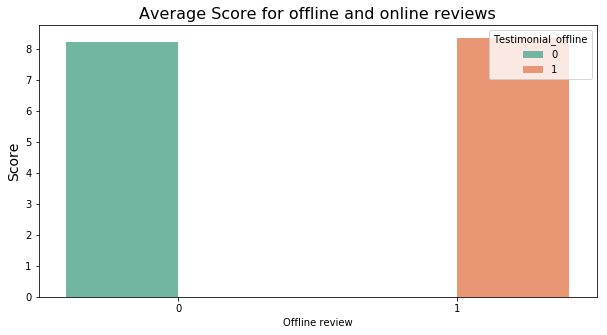

In [149]:
fig, ax =plt.subplots(figsize=(10,5))
sns.barplot(x = "Testimonial_offline"
           ,y = "Score"
           ,hue= "Testimonial_offline"
           ,data = df_class.groupby("Testimonial_offline").Score.mean().reset_index()
           ,ax = ax
           ,palette = "Set2")
ax.set_title("Average Score for offline and online reviews", fontsize=16)
ax.set_ylabel("Score", fontsize=14)
ax.set_xlabel("Offline review")

In [150]:
df_class.groupby("Testimonial_offline").Score.mean()

Testimonial_offline
0    8.230259
1    8.349426
Name: Score, dtype: float64

### CustomerEmail

See how many unique CustomerEmail do we have for each group (online and offline)

See how many (count) CustomerEmail do we have for each group

Since both numbers are not the same, we can a priori say that there are some repetead CustomerEmail in both groups. So, this result is interesting since there are some repeated CustomerEmail in offline reviews, that could help as to detect this kind of reviews in the modeling part.



In [151]:
df_class.groupby("Testimonial_offline").CustomerEmail.nunique()

Testimonial_offline
0    127757
1     19658
Name: CustomerEmail, dtype: int64

In [152]:
df_class.groupby("Testimonial_offline").CustomerEmail.count()

Testimonial_offline
0    144915
1     21476
Name: CustomerEmail, dtype: int64

### CustomerIP

See how many unique CustomerIP do we have for each group (online and offline)

See how many (count) CustomerIP do we have for each group

Since both numbers are not the same, we can a priori say that there are some repetead CustomerIP in both groups. So, this result is interesting since there are some repeated CustomerIP in offline reviews, that could help as to detect this kind of reviews in the modeling part.

In [153]:
df_class.groupby("Testimonial_offline").CustomerIP.nunique()

Testimonial_offline
0    113862
1     13721
Name: CustomerIP, dtype: int64

In [154]:
df_class.groupby("Testimonial_offline").CustomerIP.count()

Testimonial_offline
0    144915
1     21476
Name: CustomerIP, dtype: int64

### AccommodationTypeID

Replace the numbers with the corresponding accommodation type names (to do not have just the numbers)

Replace the nan values (that correspond to destination, area and country reviews) with destination 


In [155]:
df_class["AccommodationTypeID"].fillna("no_acco", inplace=True)

In [156]:
cleanup_accoType = {"AccommodationTypeID":  {1: "Aparthotel", 2: "Appartement"
                                            , 3: "Bed_breakfast", 4: "Bungalow"
                                            , 5: "Bungalowtent", 6: "Camping"
                                            , 7: "Chalet", 8: "Cruiseschip"
                                            , 9: "Gasthof" , 10: "Hostel"
                                            , 11: "Hotel", 12: "Kasteel"
                                            , 13: "Landhuis", 14: "Overig"
                                            , 15: "Pension", 16: "Vakantiehuis"
                                            , 17: "Villa", 18: "Vakantiepark"
                                            , 19: "Onbekend", 20: "Lodge"
                                            , 21: "sport_natuur", 22: "history_culture"
                                            , 23: "overig_poi", 24: "horeca"
                                            , 25: "attracties", 26: "onbeach"
                                            , 27: "restaurant"}}

In [157]:
df_class.replace(cleanup_accoType, inplace=True)

### TestimonialTextRemark

Variable with the review text

### Review length
The number of words in the review

Text(0.5, 0, 'Offline review')

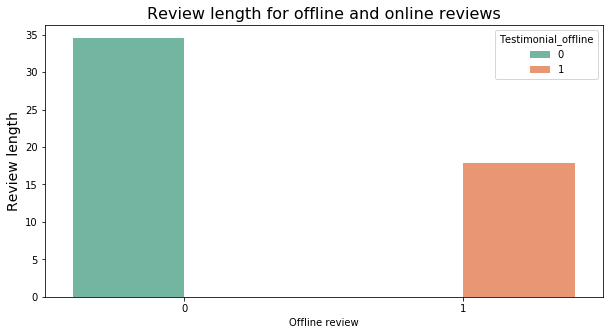

In [158]:
fig, ax =plt.subplots(figsize=(10,5))
sns.barplot(x = "Testimonial_offline"
           ,y = "rev_len"
           ,hue= "Testimonial_offline"
           ,data = df_class.groupby("Testimonial_offline").rev_len.mean().reset_index()
           ,ax = ax
           ,palette = "Set2")
ax.set_title("Review length for offline and online reviews", fontsize=16)
ax.set_ylabel("Review length", fontsize=14)
ax.set_xlabel("Offline review")

### Maximun content similarity (by CustomerIP) 

Text(0.5, 0, 'Offline review')

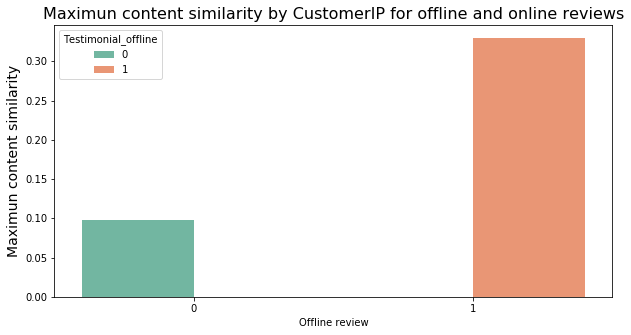

In [175]:
fig, ax =plt.subplots(figsize=(10,5))
sns.barplot(x = "Testimonial_offline"
           ,y = "max_content_similarity"
           ,hue= "Testimonial_offline"
           ,data = df_class.groupby("Testimonial_offline").max_content_similarity.mean().reset_index()
           ,ax = ax
           ,palette = "Set2")
ax.set_title("Maximun content similarity by CustomerIP for offline and online reviews", fontsize=16)
ax.set_ylabel("Maximun content similarity", fontsize=14)
ax.set_xlabel("Offline review")

### Number of reviews by customer per day

Text(0.5, 0, 'Offline review')

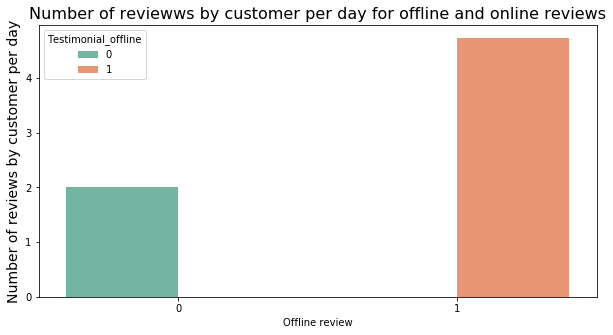

In [379]:
fig, ax =plt.subplots(figsize=(10,5))
sns.barplot(x = "Testimonial_offline"
           ,y = "num_rev_customer_day"
           ,hue= "Testimonial_offline"
           ,data = df_class.groupby("Testimonial_offline").num_rev_customer_day.mean().reset_index()
           ,ax = ax
           ,palette = "Set2")
ax.set_title("Number of reviewws by customer per day for offline and online reviews", fontsize=16)
ax.set_ylabel("Number of reviews by customer per day", fontsize=14)
ax.set_xlabel("Offline review")

In [57]:
df_class[df_class['Testimonial_offline']==1].num_rev_customer_day.quantile(0.59)

2.0

### Descriptive statistics

In [22]:
df_class[df_class['Testimonial_offline']==1].describe()

TestimonialID       EntityID  EntityIDAccommodation  EntityIDCountry  \
count   2.147600e+04   21476.000000           21476.000000     21476.000000   
mean    1.444008e+07  344898.187046          344661.880751      9877.070777   
std     8.708622e+04  274813.904597          275059.719928     62482.736453   
min     1.425572e+07    1156.000000               0.000000        10.000000   
25%     1.436289e+07  127393.000000          127124.000000        39.000000   
50%     1.447275e+07  297340.000000          297337.000000        42.000000   
75%     1.452036e+07  345847.000000          345847.000000        46.000000   
max     1.454075e+07  929479.000000          929479.000000    407025.000000   

       TestimonialRating_01_GeneralImpression          hour  \
count                                     0.0  21476.000000   
mean                                      NaN     14.910412   
std                                       NaN      4.668721   
min                                       NaN      0.000000   
25%                                       NaN     11.000000   
50%                                       NaN     15.000000   
75%                                       NaN     19.000000   
max                                       NaN     23.000000   

       Testimonial_offline  is_acco_review         Score       rev_len  \
count              21476.0    21476.000000  21476.000000  21476.000000   
mean                   1.0        0.978022      8.349426     17.826830   
std                    0.0        0.146615      1.082171     20.598664   
min                    1.0        0.000000      1.000000      0.000000   
25%                    1.0        1.000000      8.080321      5.000000   
50%                    1.0        1.000000      8.442561      9.000000   
75%                    1.0        1.000000      9.000000     23.000000   
max                    1.0        1.000000     10.000000    178.000000   

       num_rev_customer_day  avg_score_customer  avg_len_customer  \
count          21476.000000        21476.000000      21476.000000   
mean               4.731840            8.371089         19.651873   
std                8.997759            1.066758         19.488344   
min                1.000000            1.000000          0.000000   
25%                1.000000            8.098043          6.009494   
50%                1.000000            8.461204         12.485437   
75%                3.000000            9.000000         27.305000   
max               76.000000           10.000000        178.000000   

       rev_score_dev  rev_score_dev_abs  max_content_similarity  
count   2.147600e+04       2.147600e+04            21476.000000  
mean    1.124872e-14       1.467674e-14                0.329706  
std     3.743504e-14       3.622851e-14                0.409063  
min    -3.197442e-14       0.000000e+00                0.000000  
25%    -8.881784e-16       0.000000e+00                0.000000  
50%     0.000000e+00       1.776357e-15                0.104229  
75%     5.329071e-15       7.105427e-15                0.765192  
max     1.492140e-13       1.492140e-13                1.000000

In [24]:
df_class[df_class['Testimonial_offline']==0].describe()

TestimonialID       EntityID  EntityIDAccommodation  EntityIDCountry  \
count   1.449150e+05  144915.000000          144915.000000    144915.000000   
mean    1.441150e+07  286972.392975          286362.885064      5040.419681   
std     8.078160e+04  230901.382125          231249.717517     44817.384933   
min     1.425572e+07    1153.000000               0.000000        10.000000   
25%     1.434158e+07  122153.000000          122055.000000        34.000000   
50%     1.441462e+07  296805.000000          296781.000000        42.000000   
75%     1.448641e+07  312165.000000          311959.000000        42.000000   
max     1.454076e+07  929502.000000          929502.000000    407025.000000   

       TestimonialRating_01_GeneralImpression           hour  \
count                           144915.000000  144915.000000   
mean                                 8.230259      15.090246   
std                                  1.811189       4.908673   
min                                  1.000000       0.000000   
25%                                  8.000000      11.000000   
50%                                  9.000000      15.000000   
75%                                  9.000000      19.000000   
max                                 10.000000      23.000000   

       Testimonial_offline  is_acco_review          Score        rev_len  \
count             144915.0   144915.000000  144915.000000  144915.000000   
mean                   0.0        0.959783       8.230259      34.559487   
std                    0.0        0.196468       1.811189      26.908441   
min                    0.0        0.000000       1.000000       0.000000   
25%                    0.0        1.000000       8.000000      13.000000   
50%                    0.0        1.000000       9.000000      26.000000   
75%                    0.0        1.000000       9.000000      50.000000   
max                    0.0        1.000000      10.000000     383.000000   

       num_rev_customer_day  avg_score_customer  avg_len_customer  \
count         144915.000000       144915.000000     144915.000000   
mean               2.012117            8.227049         34.289020   
std                6.077110            1.632350         24.828158   
min                1.000000            1.000000          0.000000   
25%                1.000000            8.000000         15.000000   
50%                1.000000            8.526332         27.923077   
75%                1.000000            9.000000         48.000000   
max               84.000000           10.000000        383.000000   

       rev_score_dev  rev_score_dev_abs  max_content_similarity  
count   1.449150e+05      144915.000000           144915.000000  
mean    7.783597e-16           0.909125                0.097229  
std     1.364758e+00           1.017866                0.238864  
min    -7.500000e+00           0.000000                0.000000  
25%    -7.010309e-01           0.250000                0.000000  
50%    -5.882353e-02           0.600000                0.000000  
75%     4.545455e-01           1.206897                0.054112  
max     8.515152e+00           8.515152                1.000000

## 4. Predictive algorithm

In the modelling step I will fit different algorithms in order to select the best performing one (comparing with precision) using a grid search

The steps that I will follow are:
   
   - Split data into target and feautures

   - Encode categorical features
   
   - Split data into training and test set

   - Undersample and oversample the data set ( since we have that 87% of the reviews are online (verified reviews) and the remaining 13% are offline.
   
   - Select the classification algorithm that we want to fit 
   
   - Grid search with cross validation to select the best performing model

### Prepare the data for modeling

I had split the dataframe into my target variable (y) and a matrix of features (X). 

I encode categorical features.

I performed train-test-split on the data set (80% training, 20% testing)


In [16]:
def prep_data_model (df):
    df_model = df.copy()
    
    #Encode categorical variables
    df_categ=pd.get_dummies(df_model['AccommodationTypeID'], prefix='acco_type', drop_first=True )
    df_model = pd.concat([df_model.drop('AccommodationTypeID',axis=1), df_categ], axis=1).round(2)    
    
    # Select the target and features
    y = df_model['Testimonial_offline']
    X = df_model.drop(['TestimonialStatus', 'TestimonialID', 'EntityID', 'EntityIDAccommodation', 'EntityIDCountry'
                       , 'TestimonialTimestamp', 'TestimonialRating_01_GeneralImpression'
                       , 'CustomerEmail', 'CustomerIP', 'TestimonialTextRemark', 'date', 'Testimonial_offline'
                       , 'clean_text', 'rev_score_dev_abs', 'Score', 'avg_score_customer', 'max_content_similarity'
                       ], axis=1)
    
    # Split the data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    
    #return X_train_scaled, y_train, X_test_scaled, y_test, X_train, X_test
    return X_train, X_test, y_train, y_test

In [17]:
X_train, X_test, y_train, y_test= prep_data_model(df_class)

### GridSearchCV

I looped through 3 classifiers: 

   - Logistic Regression, 

   - Random Forest, 

   - Gradient Boosting Machine (GBM)

I defined “model_grid_mapping” to be a dictionary for each classifier with the classifier object and a grid of model-specific hyperparameters to be tuned.

In [18]:
grid_logistic = {"class__C":np.logspace(-3,3,7), "class__penalty":["l1","l2"]}
grid_rf = {'class__n_estimators': range(80,140,20)
           , 'class__max_features': ['auto', 'sqrt','log2']
           , 'class__max_depth' : range(6,12)
          }
grid_gbm = { 'class__learning_rate' : np.arange(0.01, 0.2, 0.05)
             , 'class__max_depth' : range(4,8)
             , 'class__n_estimators' : range(120,200,20)
           }

logit=LogisticRegression(solver='liblinear')
rf = RandomForestClassifier()
gbm = GradientBoostingClassifier()

model_grid_mapping={logit:grid_logistic, rf:grid_rf, gbm:grid_gbm}

I defined the model_selection function below to perform a GridSearch to optimize hypterparameters across five cross-validation sets for a given model. I decided to use the precision score to determine model performance.

We are using the oversampling/undersampling method after splitting the training data for cross validation. So, the five-fold validation sets are representative of a distribution in the real world. 

Luckily, imbalanced-learn has a Pipeline class that will apply the resampling only during the classifier fitting, thus allowing me to avoid some clunky for-loops and manual GridSearchCV.
Below is the code to build the pipeline for GridSearchCV hyperparameter for all Classifiers specifiyng the samplying method oversampling/ undersampling during cross-validation fitting. 

The function returns a dictionary that includes the classifier, optimal parameters from the GridSearch, and the best precision score from the validation sets.


In [19]:
smote = SMOTE(random_state=88)
adasyn = ADASYN(random_state=88)
ROS = RandomOverSampler(random_state=88)
RUS = RandomUnderSampler(random_state=88)

def model_selection(model_grid_dict, X_train, y_train, sampling_method, scoring, cv, verbose=True):
    """
    Perform a complete grid search for each model provided in the dict. based on parameter grid
    Returns two dicts. First dict is including all models and their scores/parameters.
    Second dict, best model with opt. paramters based on grid search
    
    IN:
    model_grid_dict (dict): key=model, value=paramter_grid
    X_train (df): Features for training
    y_train (df): Target variable
    sampling method: Oversampling or undersampling method
    scoring (str): evaluation metric
    cv: Number of k-fold cross validation
    verbose (bool): if True, prints best performing model
    
    OUT:
    best_model (tuple): ('Model Name', 'best_parameters')
    model_performance_list (list): list including all models, their best scores, and best_parameters
    """
    
    
    model_outcomes_list =[]
    for classifier,  grid in model_grid_mapping.items():
        model_name = str(classifier).split("(")[0]
        print("Estimating: ", model_name)
        pipeline = Pipeline([('sampling', sampling_method), ('class', classifier)])
        grid_cv = GridSearchCV(pipeline, grid, scoring = scoring, cv = cv)
        grid_cv.fit(X_train, y_train)
        best_score = grid_cv.best_score_
        best_paramters = grid_cv.best_params_
        model_outcomes_list.append((model_name, best_paramters, best_score))
        
        model_outcomes_df = pd.DataFrame(model_outcomes_list)
    
    best_score = max([x[2] for x in model_outcomes_list])
    best_model = [x[:2] for x in model_outcomes_list if x[2] == best_score][0]    
    
    if verbose==True:
        print("*************************")
        print("Best performing model is: ", best_model[0])
        print("Best paramters: ", best_model[1])
        print("*************************")
        
    return best_model, model_outcomes_list, model_outcomes_df
    
    

### Randomundersampling with Gridsearch and cv

In [236]:
best_model_RUS, model_outcomes_RUS, model_outcomes_RUS_df = model_selection(model_grid_dict = model_grid_mapping, X_train = X_train
                              , y_train = y_train, sampling_method = RUS, scoring = 'precision', cv = 5)

Estimating:  LogisticRegression
Estimating:  RandomForestClassifier
Estimating:  GradientBoostingClassifier
*************************
Best performing model is:  RandomForestClassifier
Best paramters:  {'class__max_depth': 9, 'class__max_features': 'log2', 'class__n_estimators': 80}
*************************


In [237]:
model_outcomes_RUS_df

0  \
0          LogisticRegression   
1      RandomForestClassifier   
2  GradientBoostingClassifier   

                                                   1         2  
0         {'class__C': 0.01, 'class__penalty': 'l1'}  0.229865  
1  {'class__max_depth': 9, 'class__max_features':...  0.625858  
2  {'class__learning_rate': 0.16000000000000003, ...  0.620216

In [238]:
best_params_RUS = best_model_RUS[1]
best_params_RUS

{'class__max_depth': 9,
 'class__max_features': 'log2',
 'class__n_estimators': 80}

In [239]:
params_RUS = {key.split('__')[1]:best_params_RUS[key] for key in best_params_RUS if key.startswith('class__')}

In [240]:
X_train_RUS, y_train_RUS = RUS.fit_resample(X_train, y_train)
    
rf_RUS = RandomForestClassifier(**params_RUS).fit(X_train_RUS, y_train_RUS)

#Predict values based on new parameters
y_pred_RUS = rf_RUS.predict(X_test)

confusion_matrix_RUS = confusion_matrix(y_test, y_pred_RUS)
classification_report_RUS = classification_report(y_test, y_pred_RUS)

print(classification_report_RUS)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     28965
           1       0.61      0.99      0.75      4314

    accuracy                           0.92     33279
   macro avg       0.80      0.95      0.85     33279
weighted avg       0.95      0.92      0.92     33279



### Smote sampling with Gridsearch and cv

In [241]:
best_model_smote, model_outcomes_smote, model_outcomes_smote_df = model_selection(model_grid_dict = model_grid_mapping, X_train = X_train
                              , y_train = y_train, sampling_method = smote, scoring = 'precision', cv = 5)

Estimating:  LogisticRegression


/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Estimating:  RandomForestClassifier
Estimating:  GradientBoostingClassifier
*************************
Best performing model is:  GradientBoostingClassifier
Best paramters:  {'class__learning_rate': 0.16000000000000003, 'class__max_depth': 7, 'class__n_estimators': 180}
*************************


In [242]:
model_outcomes_smote_df

0  \
0          LogisticRegression   
1      RandomForestClassifier   
2  GradientBoostingClassifier   

                                                   1         2  
0          {'class__C': 1.0, 'class__penalty': 'l2'}  0.250026  
1  {'class__max_depth': 11, 'class__max_features'...  0.654159  
2  {'class__learning_rate': 0.16000000000000003, ...  0.693010

In [243]:
best_params_smote = best_model_smote[1]
best_params_smote

{'class__learning_rate': 0.16000000000000003,
 'class__max_depth': 7,
 'class__n_estimators': 180}

In [244]:
params_smote = {key.split('__')[1]:best_params_smote[key] for key in best_params_smote if key.startswith('class__')}

In [348]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
gb_smote = GradientBoostingClassifier(**params_smote).fit(X_train_smote, y_train_smote)

#Predict values based on new parameters
y_pred_smote = gb_smote.predict(X_test)

confusion_matrix_smote = confusion_matrix(y_test, y_pred_smote)
classification_report_smote = classification_report(y_test, y_pred_smote)

print(classification_report_smote)

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     28965
           1       0.69      0.92      0.79      4314

    accuracy                           0.94     33279
   macro avg       0.84      0.93      0.88     33279
weighted avg       0.95      0.94      0.94     33279



### Adasyn with Gridsearch and cv

In [58]:
best_model_adasyn, model_outcomes_adasyn, model_outcomes_adasyn_df = model_selection(model_grid_dict = model_grid_mapping, X_train = X_train
                              , y_train = y_train, sampling_method = adasyn, scoring = 'precision', cv = 5)

Estimating:  LogisticRegression


/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Estimating:  RandomForestClassifier
Estimating:  GradientBoostingClassifier
*************************
Best performing model is:  GradientBoostingClassifier
Best paramters:  {'class__learning_rate': 0.16000000000000003, 'class__max_depth': 7, 'class__n_estimators': 180}
*************************


In [59]:
model_outcomes_adasyn_df

best_params_adasyn = best_model_adasyn[1]
best_params_adasyn

{'class__learning_rate': 0.16000000000000003,
 'class__max_depth': 7,
 'class__n_estimators': 180}

In [60]:
params_adasyn = {key.split('__')[1]:best_params_adasyn[key] for key in best_params_adasyn if key.startswith('class__')}

In [61]:
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
    
gb_adasyn = GradientBoostingClassifier(**params_adasyn).fit(X_train_adasyn, y_train_adasyn)

#Predict values based on new parameters
y_pred_adasyn = gb_adasyn.predict(X_test)

confusion_matrix_adasyn = confusion_matrix(y_test, y_pred_adasyn)
classification_report_adasyn = classification_report(y_test, y_pred_adasyn)

print(classification_report_adasyn)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     28965
           1       0.67      0.94      0.78      4314

    accuracy                           0.93     33279
   macro avg       0.83      0.93      0.87     33279
weighted avg       0.95      0.93      0.94     33279



#### Export model to a file 

We will export the best performing model to a pickle file. In our case the GBM classifier with SMOTE

In [ ]:
# Save model
import pickle

# Export model for prediction
with open('model_gb.pickle', 'wb') as model_file:
  pickle.dump(gb_smote, model_file)


In [ ]:
pickle_out = open("model_gb.pickle","wb")
pickle.dump(gb_smote, pickle_out)
pickle_out.close()

#### Copy Classifier to Cloud Storage

In [ ]:
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    # bucket_name = "your-bucket-name"
    # source_file_name = "local/path/to/file"
    # destination_blob_name = "storage-object-name"

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )


In [ ]:
upload_blob('dataproc-098183eb-e885-45d7-9bbd-3c3b25a996ef-eu','./model_gb.pickle', 'notebooks/model_gb.pickle')